In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import math
from ipywidgets import interact, widgets

from skimage.transform import resize
from scipy.misc import imsave
import imageio

from DiffuserCamUtils import *

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
def pad_image(psf, image, image_pad):
    padded = np.full(psf.shape[:2], image_pad)
    indices = list(zip(psf.shape, image.shape))
    start = [(x-y)//2 for x, y in indices]
    end = [(x+y)//2 for x, y in indices]
    padded[start[0]:end[0], start[1]:end[1]] = image
    return padded

In [4]:
def initialize(image_file, psf_file, f_lat=1, f_ax=1, type='pco', color='rgb', dim='2d'):
    try:
        im_type = image_file[-3:]
        psf_type = psf_file[-3:]
        #image = rgb2gray(np.array(Image.open(image_file, mode='r')))
        image = np.sum(np.array(Image.open(image_file, mode='r')), 2)
        
        #psf = rgb2gray(np.array(Image.open(psf_file, mode='r')))
        psf = np.sum(np.array(Image.open(psf_file, mode='r')), 2)
        
    except IOError as ex:
        print("I/O error: " + str(ex.strerror))
    
    if dim == '2d':         #embed into a 3d array
        psf = np.expand_dims(psf, 2)
        
    psf_bg = np.min(psf)
    image_bg = np.mean(image[5:15, 5:15])

    # Downsampling the images
    psf_down_shape = tuple(i//f_lat for i in psf.shape)[:2]
    image_down_shape = tuple(i//f_lat for i in image.shape)
    psf_down = resize(psf-psf_bg, psf_down_shape, mode="constant", anti_aliasing=True)
    image_down = resize(image-image_bg, image_down_shape, mode="constant", anti_aliasing=True)
    
    # Padding the rawdata image
    image_pad = np.mean(np.random.choice(image_down.flatten('C'),(15,15))) #102
    image_pad = np.mean(np.array(np.mean(image_down[:,0:10]), np.mean(image_down[0:10,:])))
    image_down = pad_image(psf_down, image_down, image_pad)
    
    if dim == '3d':
        psf_down = downsample_lat(psf_down, f_ax)

    psf_down /= norm(psf_down)
    image_down /= np.max(image_down)

    return psf_down, image_down


In [5]:
dimensions = '2d'
folder_path = '/Users/Ellin/Prototype-DiffuserCam/QuadCam_scripts/'
psf_file = folder_path + 'old_PSF.png'
image_file = folder_path + 'large_NASA/measurement.png'

psf, b = initialize(image_file, psf_file, dim=dimensions, f_lat=8)
#psf -= np.min(psf)
b -= np.min(psf)

r = 0.5    #proportion of pixels to crop out
num_cropped = int(r * b.size)
crop2d, crop3d, pad2d, pad3d, pix_crop = get_crop_pad(psf, N=num_cropped)
h = pad2d(psf)    #pad the input stack of h's

obj_shape = h.shape
up_shape = psf.shape
A, AH = get_ops(h, crop2d, pad2d, crop3d, pad3d, up_shape)


/Users/Ellin/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


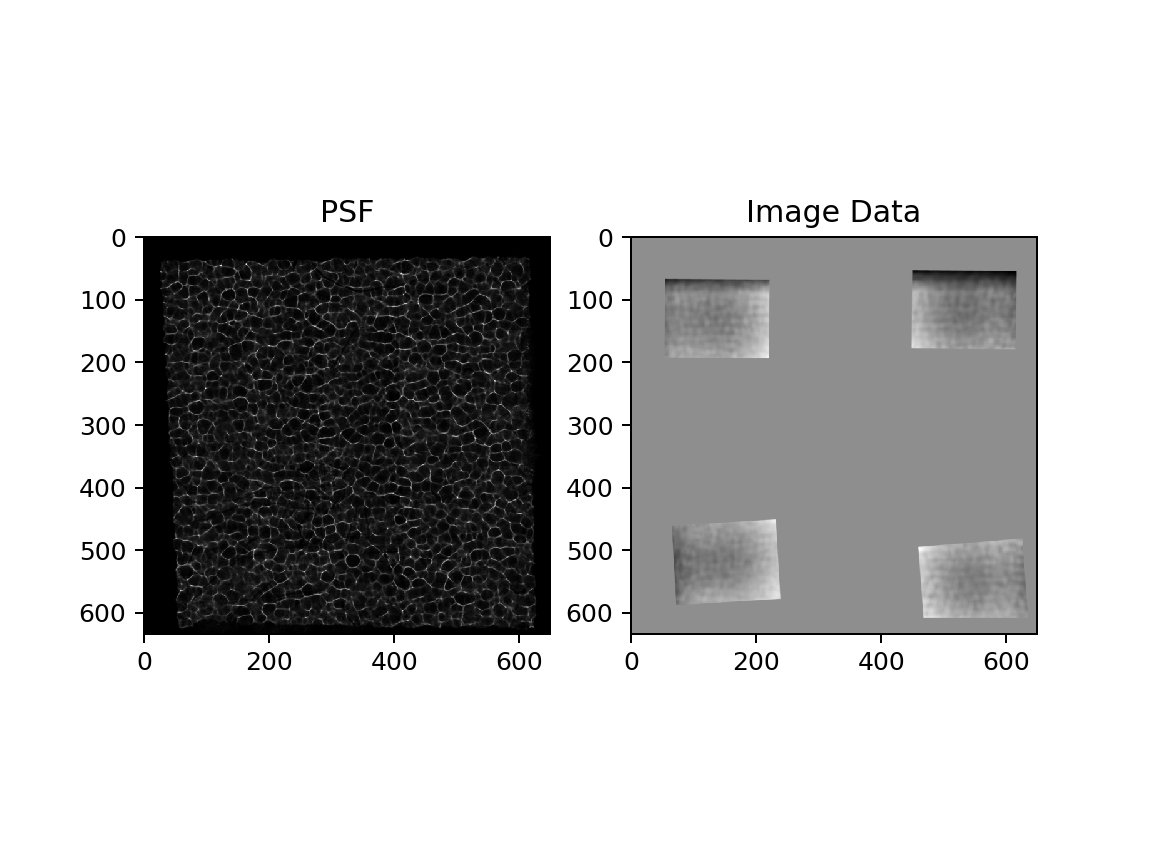

In [6]:
show_data(np.real(psf[:, :, 0]), b)

In [7]:
#setup parameters
alg = 'admm'
max_itr = 200
opt = Options(dimensions, alg, max_itr)
#opt.gamma = np.real(1.8 / np.max(Hstar * H))
opt.gamma = 1
#opt.eps = 7.4e-3        #7.4e-3 for nesterov, 4e-3 for fista
opt.del_pixels = True
opt.psf = h
opt.b = b
opt.crop2d, opt.pad2d = crop2d, pad2d
opt.crop3d, opt.pad3d = crop3d, pad3d
opt.up_shape, opt.pad_shape = up_shape, obj_shape
opt.autotune = True
opt.beta = 1.1
opt.alpha = 1.01

# tune regularization parameters.
# 2d tuning: default to 1e-4 on each, tau = 2e-3
# cartoony: 1e-3, 5e-2, 1e-3, 2e-5
# to actually see cost function going down, use tau = 1, other mu's = 1e-4
opt.mu1 = 1e-4
opt.mu2 = 1e-4
opt.mu3 = 1e-4
opt.tau = 1

In [8]:
grad_func = lambda x : grad(x, A, AH, b)
error = lambda x : objective(x, A, b, opt.tau)

<IPython.core.display.Javascript object>


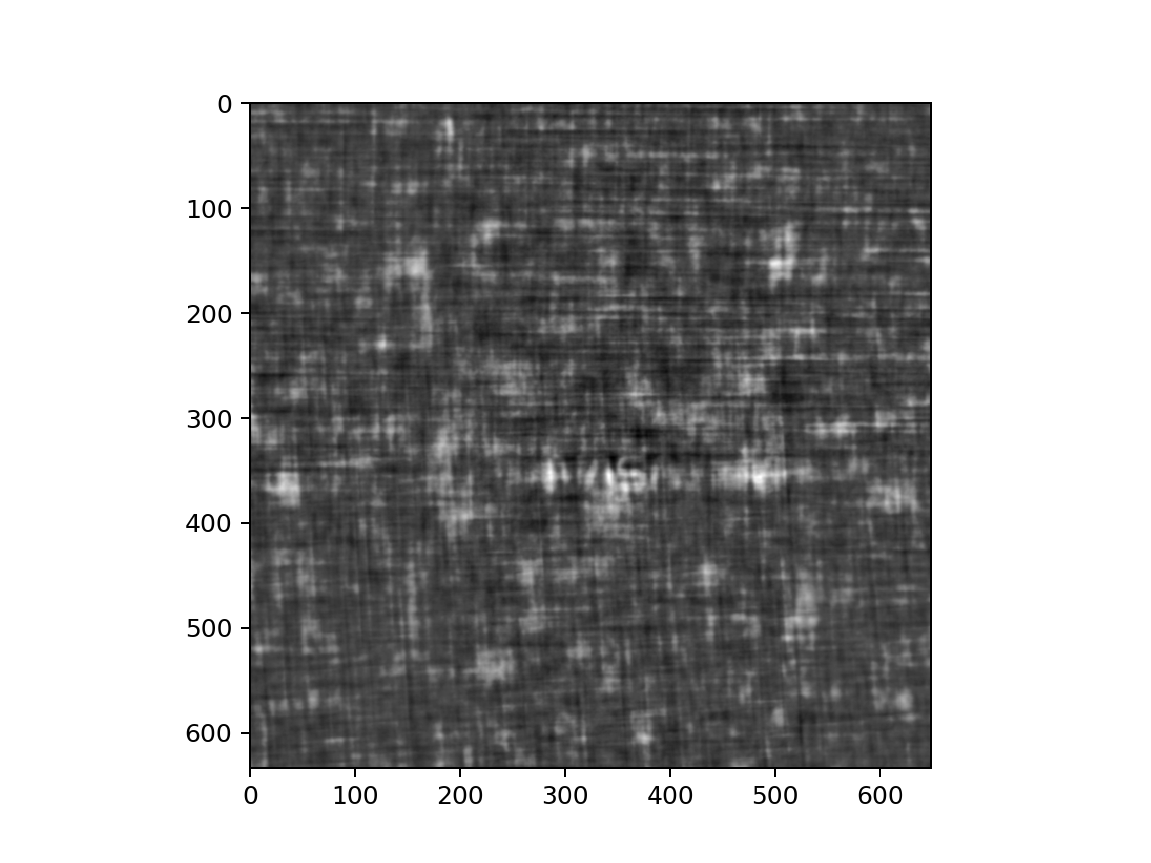

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 1
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [9]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)
imageio.imsave('recon.png', x[:,:,0])